## Задаем различные вспомогательные функции

In [108]:
def Diff(li1, li2): 
    return (list(set(li1) - set(li2)))

def mae(y_pred, targ):
    return np.abs(y_pred-targ).mean()

def get_last_els(df,val_col,n=12):
    val_idx=df.groupby(val_col).tail(n).index
    val_perc=df.iloc[val_idx,:].shape[0]/df.shape[0]
    val_idx_bool=np.array(df[val_col].index.isin(val_idx))
    print(f'Данная валидационная выборка составит {round(val_perc*100,1)}% от общей выборки по числу элементов')
    return(val_idx_bool)
     
def print_score(m,prints=True):
    n_round=5
    
    #дисперсия по деревьям
    preds = np.stack([t.predict(df_val) for t in m.estimators_])
    m_var=np.std(preds[:,0])
    
    res = [mae(m.predict(df_trn), y_trn), mae(m.predict(df_val), y_val),
                m.score(df_trn, y_trn), m.score(df_val, y_val),m_var]
    
    if hasattr(m, 'oob_score_'): res.append(round(m.oob_score_,n_round))
    
    if prints==True: 
        print(['MAE_trn','MAE_val','score_trn','score_val','T_var','OOB(if present)'])
        print([ '%.2f' % elem for elem in res]) 
    else: 
        return(res)

## Загрузка библиотек

In [109]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import lasio
from sklearn.utils import shuffle
from datetime import datetime
from copy import *
import matplotlib.pyplot as plt
import math
from sklearn.ensemble import RandomForestRegressor
from rfpimp import *
import xgboost as xgb
import random

from fastai.structured import *
from fastai.column_data import *

## Загрузка данных

In [110]:
PATH_oil="data/Gazprom2/"
PATH_oil3="data/Gazprom2/task_3/"

In [111]:
#загружаем train и test
raw_train=pd.read_csv(f'{PATH_oil3}train (3task).csv',encoding="cp1251")
raw_test=pd.read_csv(f'{PATH_oil3}test_before.csv',encoding="cp1251")
raw_test_nag=pd.read_csv(f'{PATH_oil3}test_after_X.csv',encoding="cp1251")

order=pd.read_csv(f'{PATH_oil}order3.csv',encoding="cp1251")

#и загружаем дополнительные файлы
raw_gdis=pd.read_csv(f'{PATH_oil3}additional/ГДИС.csv',encoding="cp1251")
raw_gdis2=pd.read_csv(f'{PATH_oil3}additional/ГДИС2.csv',encoding="cp1251")
raw_gtm=pd.read_csv(f'{PATH_oil3}additional/ГТМ.csv',encoding="cp1251")
raw_rigis=pd.read_csv(f'{PATH_oil3}additional/РИГИС.csv',encoding="cp1251")
raw_else=pd.read_csv(f'{PATH_oil3}additional/Доп.csv',encoding="cp1251")

## Очищаем данные и добавляем новые переменные

In [112]:
sum(raw_test['Нефть, м3'].isna())

0

In [113]:
##изменяем формат числовых данных - заменяем запятые на точки, где необходимо
train=raw_train.replace(',','.', regex=True)
test=raw_test.replace(',','.', regex=True)

##cтрочек с пустыми значениями по целевой переменной в test и train нет, убирать нечего
rows_w_oil=(train['Нефть, м3'].notna())
train=train.loc[rows_w_oil,:]

In [114]:
##так как целевая переменная - добыча нефти в м3, то убираем дублирующую переменную в другой размерности - добычу в т
test=test.drop('Нефть, т',axis=1)
train=train.drop('Нефть, т',axis=1)

In [115]:
##Переводим переменные с датой в новые колонки и категории
dtime_vars=['Дата','Дата ввода в эксплуатацию','Дата перевода в ППД']
dmonths_vars=['Месяцев с пуска','Месяцев с ввода в эксплуатацию','Месяцев с перевода в ППД']

train.loc[:,'Дата']=pd.to_datetime(train.loc[:,'Дата']);
test.loc[:,'Дата']=pd.to_datetime(test.loc[:,'Дата'])

train['Кал.месяц']=train.loc[:,'Дата'].dt.month
test['Кал.месяц']=test.loc[:,'Дата'].dt.month

train['Кал.год']=train.loc[:,'Дата'].dt.year
test['Кал.год']=test.loc[:,'Дата'].dt.year


train['Дата ввода в эксплуатацию']=(pd.TimedeltaIndex(train.loc[:,'Дата ввода в эксплуатацию'],unit="d")+datetime.datetime(1900,1,1))
test['Дата ввода в эксплуатацию']=(pd.TimedeltaIndex(test.loc[:,'Дата ввода в эксплуатацию'],unit="d")+datetime.datetime(1900,1,1))
    
train['Месяцев с ввода в эксплуатацию']=(train['Дата'].subtract(train['Дата ввода в эксплуатацию'])).dt.days//30
test['Месяцев с ввода в эксплуатацию']=(test['Дата'].subtract(test['Дата ввода в эксплуатацию'])).dt.days//30

train['Месяцев с перевода в ППД']=(train['Дата'].subtract(train['Дата ввода в эксплуатацию'])).dt.days//30
test['Месяцев с перевода в ППД']=(test['Дата'].subtract(test['Дата ввода в эксплуатацию'])).dt.days//30


train['Месяц']=train.groupby('Скважина').cumcount()+1
test['Месяц']=test.groupby('Скважина').cumcount()+1

##Записываем, какие новые категорийные переменные получились из дат, сами колонки с датами удаляем
dtime_cat_vars=['Кал.месяц','']
all_date_vars=dmonths_vars+['Месяц','Кал.месяц','Кал.год']

#убираем колонки с изначальными необработанными переменными
test=test.drop(dtime_vars,axis=1)
train=train.drop(dtime_vars,axis=1).reset_index(drop=True)

In [116]:
#по этой колонке нет данных ни по одному из наблюдений
train=train.drop(['Природный газ, м3'],axis=1)
test=test.drop(['Природный газ, м3'],axis=1)

In [117]:
##делаем нижний регистр у значимых текстовых переменных
train['Причина простоя']=train['Причина простоя'].str.lower()
test['Причина простоя']=test['Причина простоя'].str.lower()

In [118]:
##!! Месяц указан в качестве численной переменной, не категориальной
##указываем категорийные переменные
cat_vars=['Скважина','Характер работы','Состояние','Причина простоя','Агент закачки',
          'Тип скважины','Способ эксплуатации','Тип насоса','Состояние на конец месяца',
          'group','completion','work_character']+['Кал.месяц']

##и указываем числовые переменные
contin_vars_test=Diff(test.columns,cat_vars)
contin_vars_train=Diff(train.columns,cat_vars)

In [119]:
##указываем корректный тип для каждой переменной
for v in cat_vars: 
    train[v] = train[v].astype('category')
    test[v] = test[v].astype('category')
    
for v in contin_vars_train:
    #print(v)
    train[v] = train[v].astype('float32')

for v in contin_vars_test:
    test[v] = test[v].astype('float32') 

In [120]:
train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

In [121]:
order_idxs=order['well'].tolist()
len(order_idxs)

37

## Смотрим на данные

In [122]:
#в test датасет всего две даты, по которым мы предсказываем, в train 7

print(raw_test.groupby('Скважина').tail(1)['Дата'].unique())
print(raw_train.groupby('Скважина').tail(1)['Дата'].unique())

['2016-08-01' '2016-12-01']
['2017-12-01' '2013-08-01' '2017-10-01' '2014-03-01' '2016-08-01' '2017-09-01' '2013-10-01']


In [123]:
test.loc[:,cat_vars].describe().T

,count,unique,top,freq
Скважина,4156,57,4efe49f90af162c2,151
Характер работы,4148,3,НЕФ,2742
Состояние,4148,7,РАБ.,3852
Причина простоя,605,43,геологич.причина,173
Агент закачки,1399,12,Вода пресная+подтоварная.м.куб.,998
Тип скважины,544,2,Наклонно-направленно,519
Способ эксплуатации,1291,1,ЭЦН,1291
Тип насоса,1291,69,FC-450(50)-2400,101
Состояние на конец месяца,1291,2,В работе,1268
group,4156,15,ee5be9e112b427792382aec391b99b35f7f247712e6871...,504


In [124]:
for c in cat_vars:
    print(c)
    print(test[c].value_counts())

Скважина
4efe49f90af162c2    151
83be5d1c5fb93b67    147
eeface5ca8a6ff24    144
39b232e45da7c166    135
b02ff013cb23ad9b    135
aeaa64470ff6bd59    132
ddc0209847c13f1b    128
0b68e26f46bae74f    128
99306579d8299a91    127
86762013dc493dce    126
e1e6e4edd41a315e    120
0e754bc19b0d9695    115
e8abd10121f7d96d    107
6e137deda35d1d66    106
8a03ebe106c3add6    104
5ce966c2d0a84b62    103
b68bd6ef5017d242    101
da7fd1a787647089    100
a6eb6feaa197289d     99
65c27b87823926b4     98
2b59cbf6b8e46e09     77
3c4dd52dd0414853     69
074ff5b673b5e80d     68
1e6133531afe2bd9     67
d1eabf3ed0d2cdf9     67
0a6c7b090c4b4e56     67
2f168cbb00dddf74     66
d2fb33a8b5e5cb0f     66
1d5ef943084c0700     66
06413e50041826de     61
bbb5771f792375a4     58
c1446cf9b7dd85a2     57
f541721f00eca36c     56
69a24ab98854746d     56
0089b3f545d8b49c     56
97f3124fb368047e     56
2d88d48bccef66d4     54
dc8a19a94b101917     54
ec2154bcc9d1dc11     51
b144ac1e5de8c3fc     51
97a4b8aef3521c8f     49
acc4a8e

In [125]:
##Смотрим, сколько скважин с медианой около нуля
zerom_wells_train=train.groupby('Скважина')['Скважина','Нефть, м3'].median().sort_values('Нефть, м3')==0
zerom_wells_train_n=sum(zerom_wells_train.values)
train_len=len(train['Скважина'].unique())
zerom_wells_test=test.groupby('Скважина')['Скважина','Нефть, м3'].median().sort_values('Нефть, м3')==0
zerom_wells_test_n=sum(zerom_wells_test.values)
test_len=len(test['Скважина'].unique())


print(f'Из {train_len} скважин в train у {zerom_wells_train_n} или {np.round(zerom_wells_train_n/train_len*100,1)}% медиана=0')
print(f'Из {test_len} скважин в test у {zerom_wells_test_n} или {np.round(zerom_wells_test_n/test_len*100,1)}% медиана=0')

Из 175 скважин в train у [75] или [42.9]% медиана=0
Из 57 скважин в test у [16] или [28.1]% медиана=0


In [126]:
cols_per_var=train.groupby('Скважина').std().divide(train.groupby('Скважина').mean(),level='Скважина').mean(axis=0).sort_values()
#display(cols_per_var.tail(40))

## Создаём тестовый и валидационный датасеты

In [127]:
##создаем новую тестовую выборку для прогноза
test_copy=deepcopy(test)
test_copy['Дата']=pd.to_datetime(raw_test['Дата'])
test_lasts=deepcopy(test_copy.groupby('Скважина').tail(1))

test_list=[]
for i in range(0,12):
    temp_test=test_lasts.drop(['Кал.месяц','Месяц','Дата'],axis=1).drop(['Кал.год'],axis=1)
    
    temp_test['Дата']=test_lasts['Дата'].apply(lambda x:x+pd.DateOffset(months=i+1))
    temp_test['Месяц']=test_lasts['Месяц']+i+1
    temp_test['Кал.месяц']=temp_test.loc[:,'Дата'].dt.month
    temp_test['Кал.год']=temp_test.loc[:,'Дата'].dt.year
    temp_test=temp_test.drop('Дата',axis=1)
    temp_test=temp_test.set_index('Скважина').loc[order_idxs,:].reset_index(drop=False)
    test_list.append(temp_test)
    
test_fcst=pd.concat(test_list)
print(test_fcst.shape)
print(len(order_idxs)*12)

(444, 86)
444


In [128]:
#создаём большую выборку для обучения из all_train - объединяем вместе test и train
all_train=pd.concat([train,test])

In [129]:
##создаем корректную валидационную выборку для прогноза - используем последние 12 месяцев по тем скважинам, где они есть...
##...но заполняем их значениями одного и того же, 13-го месяца с конца, меняя только переменные, связанные с датой...
##...и подставляя фактические значения добычи нефти
all_train_copy=deepcopy(all_train).reset_index(drop=True)
raw_all_train=pd.concat([raw_train,raw_test]).reset_index(drop=True)

all_train_copy['Дата']=pd.to_datetime(raw_all_train['Дата'])
all_train_lasts=deepcopy(all_train_copy.groupby('Скважина').tail(13).groupby('Скважина').head(1))

val_list=[]
for i in range(0,12):
    temp_val=all_train_lasts.drop(['Кал.месяц','Месяц','Дата'],axis=1).drop(['Кал.год'],axis=1)
    
    temp_val['Дата']=all_train_lasts['Дата'].apply(lambda x:x+pd.DateOffset(months=i+1))
    temp_val['Месяц']=all_train_lasts['Месяц']+i+1
    temp_val['Кал.месяц']=temp_val.loc[:,'Дата'].dt.month
    temp_val['Кал.год']=temp_val.loc[:,'Дата'].dt.year
    temp_val=temp_val.drop('Дата',axis=1)
    val_list.append(temp_val)

val_fcst=pd.concat(val_list)

###добавляем в валидационный сет настоящие значения по целевой переменной
val_fcst=pd.merge(val_fcst.drop('Нефть, м3',axis=1),all_train.groupby('Скважина').tail(12).loc[:,['Скважина','Месяц','Нефть, м3']],
         on=['Скважина','Месяц'])

print(val_fcst.shape)
print(all_train_lasts.shape)

(2673, 86)
(232, 87)


In [130]:
###создаём новый train, убирая наблюдения за последние 12 месяцев - которые попали в валидационный датасет
val_idxs=all_train.groupby('Скважина').tail(12).index
const_train=deepcopy(all_train.drop(val_idxs,axis=0))

In [131]:
#display(all_train_lasts.sort_values(['Скважина','Месяц']).head())
#display(val_fcst.sort_values(['Скважина','Месяц']).head())
#display(all_train.sort_values(['Скважина','Месяц']).groupby('Скважина').tail(12).head())

In [132]:
## правим в созданных заново датасетах категории
for v in cat_vars: 
    all_train[v] = all_train[v].astype('category')
    const_train[v] = const_train[v].astype('category')
    test_fcst[v] = test_fcst[v].astype('category')
    val_fcst[v] = val_fcst[v].astype('category')
    
for v in contin_vars_train:
    all_train[v] = all_train[v].astype('float32')
    const_train[v] = const_train[v].astype('float32')
    test_fcst[v] = test_fcst[v].astype('float32')
    val_fcst[v] = val_fcst[v].astype('float32')
    
test_fcst=test_fcst.set_index('Скважина').reindex(order['well']).reset_index(drop=False)
test_fcst['Скважина'] = test_fcst['Скважина'].astype('category')

In [133]:
test_fcst=test_fcst.drop('Нефть, м3',axis=1)

In [134]:
##убираем из выборки для обучения строки, которые есть в валидационной выборке
val_idx=get_last_els(all_train,'Скважина',12)
all_train=all_train[np.logical_not(val_idx)]

Данная валидационная выборка составит 14.0% от общей выборки по числу элементов


In [135]:
test_wells=test['Скважина'].unique().tolist()
train_wells=train['Скважина'].unique().tolist()
const_train_wells=const_train['Скважина'].unique().tolist()

val_on_test=val_fcst.set_index(['Скважина']).loc[test_wells,:].reset_index(drop=False)

In [136]:
#display(test_fcst.tail(10))
#display(order.tail(10))

## Убираем переменные, скорелированные с целевой, которых нет в тестовом датасете

In [137]:
##Кажется достаточно логичным, что переменные, связанные с добычей воды и газа, 
#кореллируют с целевой переменной - добычей нефти
#также по месяцам варьируется количество часов работы 
##В прогнозном периоде этих данных у нас не будет, поэтому мы хотим создать модель, которая работает без них
##для этого мы убираем их из нашего train датасета
corr_cols_wtarg=['Нефть, м3','Попутный газ, м3','Добыча растворенного газа, м3',
                  'Обводненность (масса), %','Жидкость, м3','Вода, т','Жидкость, т','Дебит нефти','Время работы, ч','Дебит жидкости']
corr_cols=['Попутный газ, м3','Добыча растворенного газа, м3',
                  'Обводненность (масса), %','Жидкость, м3','Вода, т','Жидкость, т','Дебит нефти','Время работы, ч','Дебит жидкости']

НЕФ


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbde63b4d68>], dtype=object)

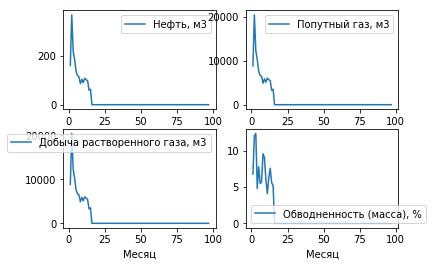

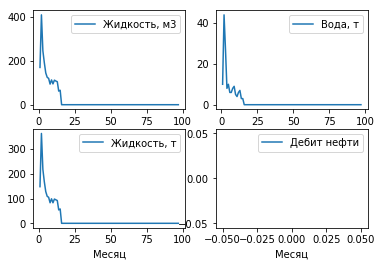

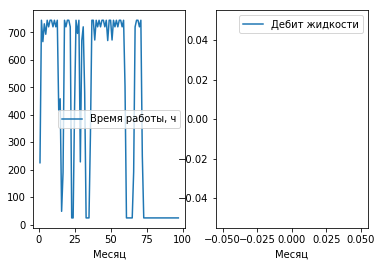

In [138]:
##смотрим по произвольным скважинам как ведут себя эти переменные визуально

temp=train.loc[:,corr_cols+['Нефть, м3']+['Скважина']+['Месяц','Характер работы']].reset_index(drop=True).set_index('Скважина')

#смотрим произвольные скважины

well=temp.index.unique()[random.randint(0,len(temp.index.unique())-1)]
print(temp.loc[well,'Характер работы'][0])

fig, axes = plt.subplots(nrows=2, ncols=2)

temp.loc[well,:].plot('Месяц','Нефть, м3',subplots=True,ax=axes[0,0])
temp.loc[well,:].plot('Месяц',corr_cols[0],subplots=True,ax=axes[0,1])
temp.loc[well,:].plot('Месяц',corr_cols[1],subplots=True,ax=axes[1,0])
temp.loc[well,:].plot('Месяц',corr_cols[2],subplots=True,ax=axes[1,1])

fig2, axes2 = plt.subplots(nrows=2, ncols=2)

temp.loc[well,:].plot('Месяц',corr_cols[3],subplots=True,ax=axes2[0,0])
temp.loc[well,:].plot('Месяц',corr_cols[4],subplots=True,ax=axes2[0,1])
temp.loc[well,:].plot('Месяц',corr_cols[5],subplots=True,ax=axes2[1,0])
temp.loc[well,:].plot('Месяц',corr_cols[6],subplots=True,ax=axes2[1,1])

fig3, axes3 = plt.subplots(nrows=1, ncols=2)

temp.loc[well,:].plot('Месяц',corr_cols[7],subplots=True,ax=axes3[0])
temp.loc[well,:].plot('Месяц',corr_cols[8],subplots=True,ax=axes3[1])

In [139]:
#Смотрим на значения этого набора переменных по произвольным скважинам
test_wells_std=test[corr_cols+['Скважина']].groupby('Скважина').agg('std')
test_wells_mean=test[corr_cols+['Скважина']].groupby('Скважина').agg('mean')
test_wells_std_perc=test_wells_std.div(test_wells_mean,level='Скважина')
display(test_wells_std.head(),test_wells_mean.head(),test_wells_std_perc.head())

,"Попутный газ, м3","Добыча растворенного газа, м3","Обводненность (масса), %","Жидкость, м3","Вода, т","Жидкость, т",Дебит нефти,"Время работы, ч",Дебит жидкости
Скважина,,,,,,,,,
0089b3f545d8b49c,6752.878418,6752.867188,4.261016,85.149498,16.345047,74.859573,1.366332,123.940811,1.564636
06413e50041826de,14018.119141,14018.105469,4.192035,244.664383,23.821423,214.379959,2.316287,115.198357,2.782858
074ff5b673b5e80d,6647.073242,6647.073242,8.037237,236.533356,103.409416,221.849548,NaN,127.673698,NaN
0a6c7b090c4b4e56,26442.664062,26442.658203,31.185589,1731.971191,1202.445679,1688.570557,8.628292,320.382080,10.686368
0b68e26f46bae74f,3050.514404,3050.514893,21.249994,47.611580,25.943470,42.185959,1.388484,91.807632,1.465082


,"Попутный газ, м3","Добыча растворенного газа, м3","Обводненность (масса), %","Жидкость, м3","Вода, т","Жидкость, т",Дебит нефти,"Время работы, ч",Дебит жидкости
Скважина,,,,,,,,,
0089b3f545d8b49c,26218.660156,26218.671875,7.921429,384.075012,27.339821,337.740723,11.509521,701.053589,14.058571
06413e50041826de,45625.164062,45625.164062,7.713115,677.442810,45.108688,595.122925,18.213003,705.803284,22.190475
074ff5b673b5e80d,1076.058838,1076.058838,1.388235,39.823528,17.514706,37.367645,NaN,704.411743,NaN
0a6c7b090c4b4e56,35398.582031,35398.597656,51.559700,2595.366455,1750.953125,2530.015381,34.642731,525.432861,120.961540
0b68e26f46bae74f,7422.226562,7422.230469,21.860937,149.567581,28.700233,134.295700,2.612731,711.187500,4.494286


,"Попутный газ, м3","Добыча растворенного газа, м3","Обводненность (масса), %","Жидкость, м3","Вода, т","Жидкость, т",Дебит нефти,"Время работы, ч",Дебит жидкости
Скважина,,,,,,,,,
0089b3f545d8b49c,0.257560,0.257559,0.537910,0.221700,0.597848,0.221648,0.118713,0.176792,0.111294
06413e50041826de,0.307245,0.307245,0.543494,0.361159,0.528089,0.360228,0.127178,0.163216,0.125408
074ff5b673b5e80d,6.177239,6.177239,5.789535,5.939538,5.904148,5.936942,NaN,0.181249,NaN
0a6c7b090c4b4e56,0.746998,0.746997,0.604844,0.667332,0.686738,0.667415,0.249065,0.609749,0.088345
0b68e26f46bae74f,0.410997,0.410997,0.972053,0.318328,0.903946,0.314127,0.531430,0.129091,0.325988


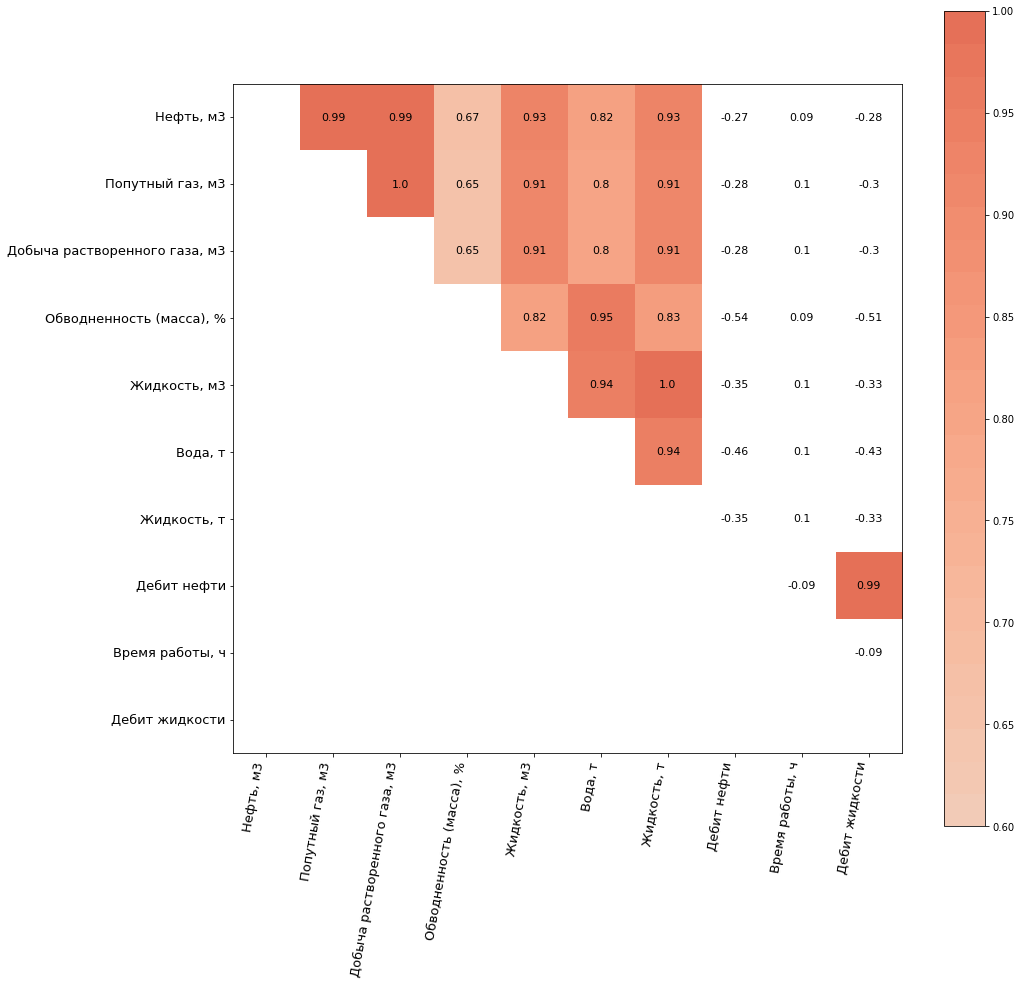

/home/paperspace/fastai/data/Gazprom2/corr_heatmap.png

In [140]:
##Смотрим на уровень корелляции между данными переменными на тепловой карте
plot_link=f'{PATH_oil}corr_heatmap.png'
corr_heatmap=plot_corr_heatmap(test[['Нефть, м3']+corr_cols], figsize=(15,15), label_fontsize=13, value_fontsize=11,save=plot_link)

FileLink(plot_link)

In [141]:
##Мы видим, что прямой корелляции между Нефть, м3 и "Дебит нефти" "Время работы" и "Дебит жидкости" нет
##Зато есть практически полная корелляция между Дебитом нефти и Дебитом жидкости

## Определяем основные предпосылки в модели и делаем предобработку данных

In [142]:
#выбираем используемые train и test датасеты. Здесь - используем датасеты со всеми переменными
#переименование переменных - осталось для удобства изменения на другой набор тестовых/валидационных датасетов для той же модели
cur_train=const_train.drop(corr_cols,axis=1)
cur_val=val_fcst.drop(corr_cols,axis=1)
cur_test=test_fcst.drop(corr_cols,axis=1)
cur_train_sub=all_train.drop(corr_cols,axis=1)

In [143]:
#Используем функцию proc_df из библиотеки fast.ai для предобработки данных
#Заполняет NA, нормализация количественных признаков возле среднего и перевод качественных в их индексы
#Также при наличии NA создаются новые переменные, запоминающие, в каких местах были NA
df_trn, y_trn, nas, mapper = proc_df(cur_train, 'Нефть, м3', do_scale=True)
df_val, y_val, nas, mapper = proc_df(cur_val, 'Нефть, м3', do_scale=True,mapper=mapper,na_dict=nas)

## Первичный запуск алгоритма случайного леса

In [144]:
#сначала запускаем модель со всеми имеющимися переменными, кроме скорелированных
m_rf_all = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                         n_jobs=-1, oob_score=True)

%time m_rf_all.fit(df_trn, pd.DataFrame(y_trn));
print_score(m_rf_all)
RF_preds_val = m_rf_all.predict(df_val.values)

CPU times: user 6.75 s, sys: 16 ms, total: 6.77 s
Wall time: 1.18 s
['MAE_trn', 'MAE_val', 'score_trn', 'score_val', 'T_var', 'OOB(if present)']
['18.95', '106.95', '0.98', '0.38', '271.02', '0.91']


## Смотрим эффективность прогноза на валидационном датасете

In [145]:
## Делаем таблицу для сравнения фактических значений на валидационном датасете и предсказаний
val_preds_df=deepcopy(df_val)
val_preds_df['Preds']=RF_preds_val
val_preds_df['Нефть, м3']=y_val
val_preds_df['MAE']=np.abs(val_preds_df['Preds']-val_preds_df['Нефть, м3'])
val_preds_df=val_preds_df.set_index('Скважина')

In [146]:
##выделяем отдельно скважины с нулевой медианой
val_zeros_temp=(val_preds_df['Нефть, м3'].groupby('Скважина').median()==0)
val_zeros=val_zeros_temp.index[val_zeros_temp.values]
val_preds_df_zeros=val_preds_df.loc[val_zeros,:]
val_preds_df_nonzeros=val_preds_df.drop(val_zeros,axis=0)

print(val_preds_df_zeros.shape,val_preds_df_nonzeros.shape,val_preds_df.shape)

(1236, 133) (1437, 133) (2673, 133)


In [147]:
##смотрим по каким ненулевым скважинам наихудший MAE
val_preds_df.groupby('Скважина').mean().MAE.sort_values().tail(15)

Скважина
2       628.193463
58      685.637679
21      796.279989
65      888.478559
98      929.663000
75      963.448560
94     1030.311011
171    1068.755005
152    1071.722496
78     1152.442485
118    1414.859985
28     1548.441398
84     1684.349144
7      1891.215967
154    2472.978775
Name: MAE, dtype: float64

In [148]:
##смотрим по каким ненулевым скважинам наилучший MAE
val_preds_df_nonzeros.groupby('Скважина').mean().MAE.sort_values().head(15)

Скважина
68      4.102601
47      5.235622
49      7.263000
12      7.432054
40     10.763268
226    11.374734
229    11.874937
153    12.645176
110    12.677562
34     13.081568
123    13.606691
20     13.990750
25     15.602087
227    15.739449
138    17.555159
Name: MAE, dtype: float64

33.0


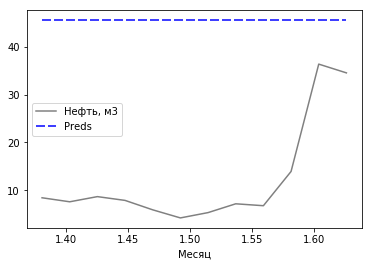

In [149]:
##Cмотрим на предсказания по нескольким произвольным скважинам
rand_val_well=random.choice(val_preds_df.index.unique().tolist())
cur_val_well=128

ax1 = plt.gca()
print(round(val_preds_df.loc[cur_val_well,'MAE'].mean(),0))
val_preds_df.loc[cur_val_well,:].plot('Месяц','Нефть, м3',c='grey',ax=ax1)
val_preds_df.loc[cur_val_well,:].plot('Месяц','Preds',c='blue',ax=ax1,dashes=[6,2])

## Выбираем значимые для прогноза признаки через random forest

In [150]:
#Встроенная в random forest rf_feat_importance работает некорректно - она неправильно учитывает скорелированные переменные
#Поэтому для прогноза мы используем пакет importances, где значимость переменных считается корректно
#fi = rf_feat_importance(m_rf, df_trn);

imp = importances(m_rf_all, df_val, pd.DataFrame(y_val)) # permutation
#dep = oob_dependences(m_rf, df_trn) #dependencies

In [151]:
imp.head(40)

,Importance
Feature,
kprod_calc,0.700562
completion,0.109508
pres_atm,0.106560
Вязкость жидкости в пласт. условиях,0.034714
Обводненность,0.028960
h_vert,0.022255
Характер работы,0.011983
group,0.006649
X,0.005381


In [152]:
##Убираем из переменных вспомогательные переменные, указывающие на то, где есть NA, возникшие после обработки
imp_cols=imp.reset_index()['Feature'].values
imp_cols_adj=[c for c in imp_cols if c.lower()[-3:] != '_na']

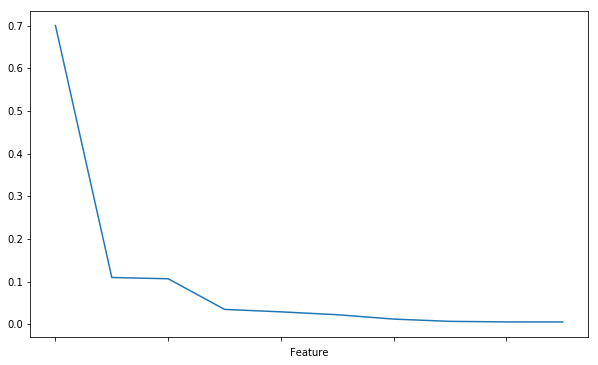

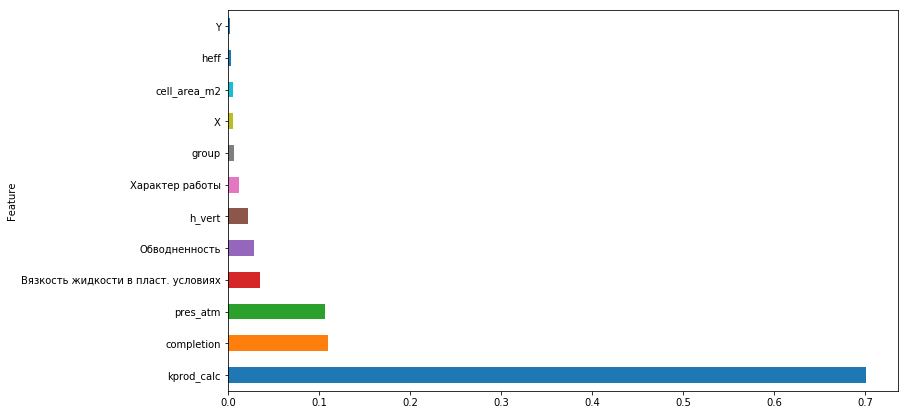

In [153]:
#смотрим значимость переменных, и насколько быстро она убывает
def plot_fi(fi): return fi[0:12].reset_index(drop=False).plot('Feature', 'Importance', 'barh', figsize=(12,7), legend=False)
imp[0:10].reset_index(drop=False).plot('Feature', 'Importance', figsize=(10,6), legend=False)
plot_fi(imp)

In [154]:
#Запоминаем 25 и 50 самых значимых переменных по random forest в отдельные переменные
imp_cols25=imp_cols_adj[0:25]+['Кал.месяц']+['Месяц']
imp_cols50=imp_cols_adj[0:50]+['Кал.месяц']+['Месяц']
#print(imp_cols25)
#print(imp_cols50)

## Пробуем строить более простые модели с меньшим числом переменных

In [155]:
#выбираем используемые train и test датасеты. Здесь - используем датасеты c 50 главными переменными
cur_train=const_train.loc[:,imp_cols50+['Нефть, м3']]
cur_val=val_fcst.loc[:,imp_cols50+['Нефть, м3']]

df_trn, y_trn, nas, mapper = proc_df(cur_train, 'Нефть, м3', do_scale=True)
df_val, y_val, nas, mapper = proc_df(cur_val, 'Нефть, м3', do_scale=True,mapper=mapper,na_dict=nas)

m_rf50 = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                         n_jobs=-1, oob_score=True)
%time m_rf50.fit(df_trn, pd.DataFrame(y_trn));

print_score(m_rf50)

CPU times: user 5.84 s, sys: 8 ms, total: 5.85 s
Wall time: 1.01 s
['MAE_trn', 'MAE_val', 'score_trn', 'score_val', 'T_var', 'OOB(if present)']
['19.74', '102.95', '0.97', '0.40', '86.83', '0.90']


In [156]:
#выбираем используемые train и test датасеты. Здесь - используем датасеты c 50 главными переменными
cur_train=const_train.loc[:,imp_cols25+['Нефть, м3']]
cur_val=val_fcst.loc[:,imp_cols25+['Нефть, м3']]

df_trn, y_trn, nas, mapper = proc_df(cur_train, 'Нефть, м3', do_scale=True)
df_val, y_val, nas, mapper = proc_df(cur_val, 'Нефть, м3', do_scale=True,mapper=mapper,na_dict=nas)

m_rf25 = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                         n_jobs=-1, oob_score=True)
%time m_rf25.fit(df_trn, pd.DataFrame(y_trn));

print_score(m_rf25)

CPU times: user 4.29 s, sys: 8 ms, total: 4.3 s
Wall time: 771 ms
['MAE_trn', 'MAE_val', 'score_trn', 'score_val', 'T_var', 'OOB(if present)']
['21.22', '97.84', '0.97', '0.48', '96.40', '0.90']


In [157]:
##как видим, в более простых моделях MAE на валидационном датасете немного снизился
##зато заметно снизилась дисперсия по деревьям, увеличилась объясняющая сила на валидационном датасете
##также немного вырос MAE на train датасете - возможно, снизился оверфит

## Делаем прогноз на тестовом датасете

In [158]:
#выбираем используемые переменные для итогового прогноза
cur_train=const_train.loc[:,imp_cols25+['Нефть, м3']]
cur_val=val_fcst.loc[:,imp_cols25+['Нефть, м3']]
cur_test=test_fcst.loc[:,imp_cols25]

#для прогноза мы используем всю выборку train, без валидации
cur_train_sub=all_train.loc[:,imp_cols25+['Нефть, м3']]

df_trn, y_trn, nas, mapper = proc_df(cur_train, 'Нефть, м3', do_scale=True)
df_val, y_val, nas, mapper = proc_df(cur_val, 'Нефть, м3', do_scale=True,mapper=mapper,na_dict=nas)
df_test, _, nas, mapper = proc_df(cur_test, do_scale=True,mapper=mapper,na_dict=nas)
df_train_sub, y_sub, nas, mapper = proc_df(cur_train_sub,'Нефть, м3',do_scale=True,mapper=mapper,na_dict=nas)

m_rf25 = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                         n_jobs=-1, oob_score=True)
%time m_rf25.fit(df_train_sub, pd.DataFrame(y_trn));

RF25_test_preds=np.round(m_rf25.predict(df_test.values),4)

CPU times: user 4.4 s, sys: 8 ms, total: 4.41 s
Wall time: 784 ms


In [159]:
sub_out25=pd.DataFrame(RF25_test_preds)
subm_fn=f'{PATH_oil}tmp/final_subm25.csv'
print("Итого строчек в сабмите", sub_out25.shape[0])

sub_out25.to_csv(subm_fn, index=True,encoding="cp1251",header=False)
FileLink(subm_fn)

Итого строчек в сабмите 444


/home/paperspace/fastai/data/Gazprom2/tmp/final_subm25.csv